# Model Consolidation

### Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt   
%matplotlib inline
from music21 import *
from IPython.display import Audio
from intervaltree import Interval,IntervalTree
import pandas as pd
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import sklearn.model_selection as model_selection
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import tensorflow as tf

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore')




### Import csv features which were extracted from earlier Data PreProcessing notebook

In [5]:
X_train_w = pd.read_csv('../data/X_train_w.csv',index_col = 0)
X_train_m = pd.read_csv('../data/X_train_m.csv',index_col = 0)
X_train_c = pd.read_csv('../data/X_train_c.csv',index_col = 0)
X_test_w = pd.read_csv('../data/X_test_w.csv',index_col = 0)
X_test_m = pd.read_csv('../data/X_test_m.csv',index_col = 0)
X_test_c = pd.read_csv('../data/X_test_c.csv',index_col = 0)
y_train_w = pd.read_csv('../data/y_train_w.csv',index_col = 0)
y_train_m = pd.read_csv('../data/y_train_m.csv',index_col = 0)
y_train_c = pd.read_csv('../data/y_train_c.csv',index_col = 0)
y_test_w = pd.read_csv('../data/y_test_w.csv',index_col = 0)
y_test_m = pd.read_csv('../data/y_test_m.csv',index_col = 0)
y_test_c = pd.read_csv('../data/y_test_c.csv',index_col = 0)

In [3]:
print('Shape of Wav Data :')
print( X_train_w.shape, y_train_w.shape , X_test_w.shape , y_test_w.shape)

Shape of Wav Data :
(263, 167) (263, 1) (66, 167) (66, 1)


In [4]:
print('Shape of MIDI Data :')
print( X_train_m.shape, y_train_m.shape , X_test_m.shape , y_test_m.shape)

Shape of MIDI Data :
(263, 10) (263, 1) (66, 10) (66, 1)


In [5]:
print('Shape of Combined Wav and MIDI Data :')
print( X_train_c.shape, y_train_c.shape , X_test_c.shape , y_test_c.shape)

Shape of Combined Wav and MIDI Data :
(263, 176) (263, 1) (66, 176) (66, 1)


# Models

## 1. Logistic Regression

### 1.1 Spectral (WAV) Data Only

#### 1.1.1 Baseline model

In [6]:
#Create Baseline Logistic Model
lr = LogisticRegression(C = 0.5, solver='liblinear', multi_class='auto')
lr.fit(np.array(X_train_w), np.array(y_train_w))
#cross validation with 5 fold on training data
scores = cross_val_score(estimator = lr, X=X_train_w, y=y_train_w.values.ravel(), cv=5, n_jobs=1)
# output (printed to text file and displayed within notebook)
output_file = open('../output/output_file', 'a')
model_no = 'Model #: 1.1.1\n'
model_type = 'Linear Regression Baseline Model (wav data only)\n'
model_scores = f'CV Scores: {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 1.1.1
 Linear Regression Baseline Model (wav data only)
 CV Scores: [0.88679245 0.88679245 0.86792453 0.90384615 0.94230769]
 CV Average and standard deviation: 0.8975326560232221 +/- 0.02510780470472868



#### 1.1.2 PCA components

Explained Variance with 1 Principal Components: 84.97%
Explained Variance with 2 Principal Components: 94.32%
Explained Variance with 3 Principal Components: 96.57%
Explained Variance with 4 Principal Components: 97.40%
Explained Variance with 5 Principal Components: 98.08%
Explained Variance with 6 Principal Components: 98.42%
Explained Variance with 7 Principal Components: 98.69%
Explained Variance with 8 Principal Components: 98.95%
Explained Variance with 9 Principal Components: 99.14%
Explained Variance with 10 Principal Components: 99.27%
Explained Variance with 11 Principal Components: 99.36%
Explained Variance with 12 Principal Components: 99.43%
Explained Variance with 13 Principal Components: 99.49%
Explained Variance with 14 Principal Components: 99.55%
Explained Variance with 15 Principal Components: 99.60%
Explained Variance with 16 Principal Components: 99.64%
Explained Variance with 17 Principal Components: 99.68%
Explained Variance with 18 Principal Components: 99.71%
E

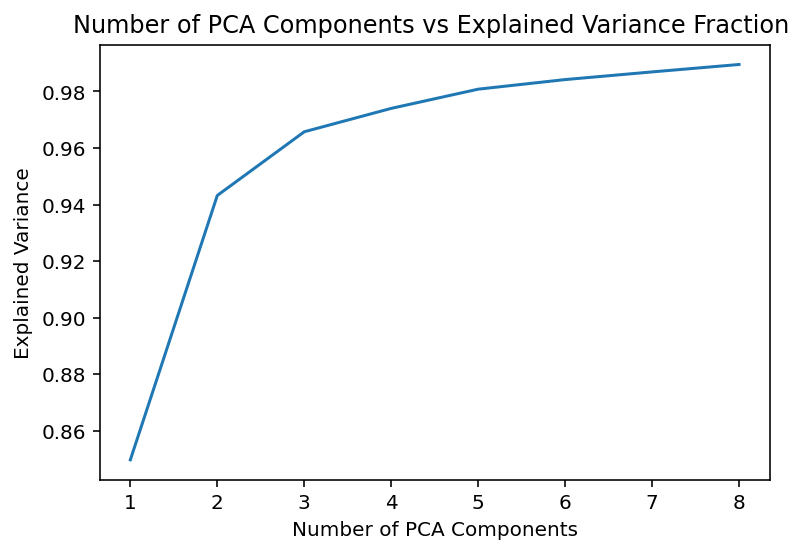

Model #: 1.1.2
 Logistic Regression with PCA (wav data only)
 CV Scores [0.67924528 0.69811321 0.66037736 0.71153846 0.69230769]
 CV Average and standard deviation: 0.6883164005805515 +/- 0.017401420621599144



In [7]:
#all possible values of principal components can go up to the number of features
all_possible_k = range(1,len(X_train_w.columns))

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca = PCA(n_components = i)
    pca.fit(X_train_w)
    train_pca = pca.transform(X_train_w)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    
    #Logistic Regression Model with PCA
    lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
    lr.fit(train_pca,y_train_w)

plt.plot(all_possible_k[0:8], all_possible_k_variance[0:8])
for x,y in zip(all_possible_k,all_possible_k_variance):
    print("Explained Variance with {} Principal Components: {:.2%}".format(x,y))

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
# save plot to output/plots folder
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')
plt.savefig('../output/plots/1.1.2 PCA Components.png')
plt.show()

pca = PCA(n_components = 5)
pca.fit(X_train_w)
X_train_pca = pca.transform(X_train_w)

lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
lr.fit(X_train_pca,y_train_w)
scores = cross_val_score(estimator = lr, X=X_train_pca, y=y_train_w.values.ravel(), cv=5, n_jobs=1)
output_file = open('../output/output_file', 'a')
model_no = 'Model #: 1.1.2\n'
model_type = 'Logistic Regression with PCA (wav data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

### 1.2 MIDI Data Only 

#### 1.2.1 Baseline model

In [8]:
lr = LogisticRegression(C = 0.5, solver='liblinear', multi_class='auto')
lr.fit(np.array(X_train_m), np.array(y_train_m))
scores = cross_val_score(estimator = lr, X=X_train_m, y=y_train_m, cv=5, n_jobs=1)
# save and print output
output_file = open('../output/output_file', 'a')
model_no = 'Model #: 1.2.1\n'
model_type = 'Logistic Regression Baseline Model (midi data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 1.2.1
 Logistic Regression Baseline Model (midi data only)
 CV Scores [0.69811321 0.75471698 0.71698113 0.65384615 0.76923077]
 CV Average and standard deviation: 0.7185776487663279 +/- 0.041190529521200045



#### 1.2.2 PCA components

[0.8472469251566341, 0.9999994828649595, 0.9999999950423859, 0.9999999979326265, 0.9999999995373897, 0.9999999998110076, 0.9999999999006716, 0.9999999999631858]


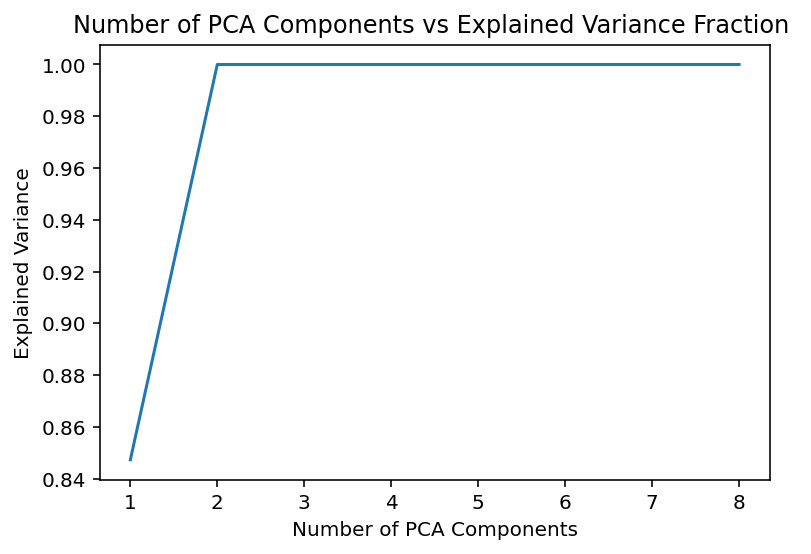

Model #: 1.2.2
 Logistic Regression with PCA (midi data only)
 CV Scores [0.47169811 0.47169811 0.16981132 0.48076923 0.48076923]
 CV Average and standard deviation: 0.4149492017416546 +/- 0.1226360559071233



In [9]:
#all possible values of principal components can go up to the number of features
all_possible_k = range(1,len(X_train_m.columns))

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca = PCA(n_components = i)
    pca.fit(X_train_m)
    train_pca = pca.transform(X_train_m)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    
    #Logistic Regression Model with PCA
    lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
    lr.fit(train_pca,y_train_w)

plt.plot(all_possible_k[0:8], all_possible_k_variance[0:8])
print(all_possible_k_variance[0:8])

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
# save plot
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')
plt.savefig('../output/plots/1.2.2 PCA Components.png')
plt.show()

pca = PCA(n_components = 5)
pca.fit(X_train_m)
X_train_pca = pca.transform(X_train_m)

lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
lr.fit(X_train_pca,y_train_w)
scores = cross_val_score(estimator = lr, X=X_train_pca, y=y_train_w, cv=5, n_jobs=1)
# save and print output
output_file = open('../output/output_file', 'a')
model_no = 'Model #: 1.2.2\n'
model_type = 'Logistic Regression with PCA (midi data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

### 1.3 Combined Data (WAV & MIDI) 

#### 1.3.1 Baseline model

In [10]:
lr = LogisticRegression(C = 0.5, solver='liblinear', multi_class='auto')
lr.fit(np.array(X_train_c), np.array(y_train_c))
scores = cross_val_score(estimator = lr, X=X_train_c, y=y_train_c, cv=5, n_jobs=1)
# save and print output
output_file = open('../output/output_file', 'a')
model_no = 'Model #: 1.3.1\n'
model_type = 'Logistic Regression Baseline Model (combined midi and wav data)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 1.3.1
 Logistic Regression Baseline Model (combined midi and wav data)
 CV Scores [0.81132075 0.8490566  0.88679245 0.80769231 0.92307692]
 CV Average and standard deviation: 0.8555878084179971 +/- 0.04432768457200831



#### 1.3.2 PCA components

[0.8472467564714535, 0.9999993006005323, 0.9999998191050802, 0.9999999250480672, 0.9999999510448121, 0.9999999628415001, 0.9999999703478009, 0.9999999753281146]


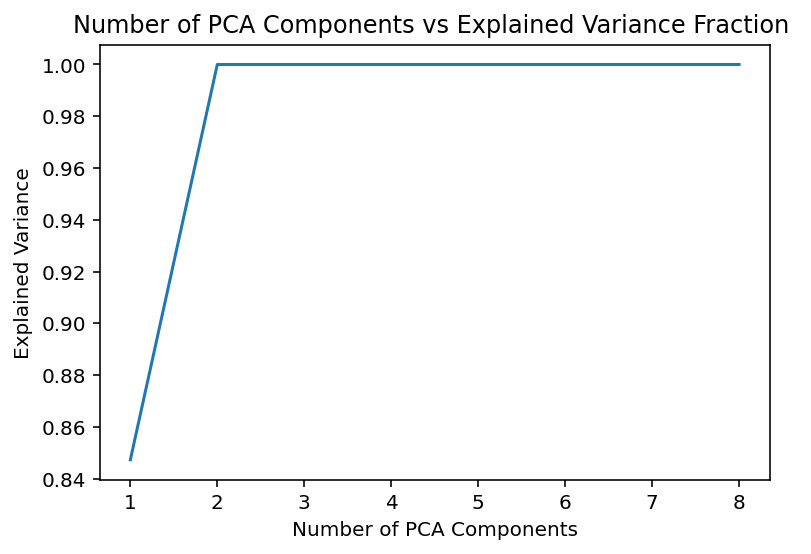

Model #: 1.3.2
 Logistic Regression with PCA (combined midi and wav data)
 CV Scores [0.47169811 0.43396226 0.43396226 0.48076923 0.46153846]
 CV Average and standard deviation: 0.4563860667634253 +/- 0.01929351431111436



In [11]:
#all possible values of principal components can go up to the number of features
all_possible_k = range(1,len(X_train_c.columns))

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca = PCA(n_components = i)
    pca.fit(X_train_c)
    train_pca = pca.transform(X_train_c)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    
    #Logistic Regression Model with PCA
    lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
    lr.fit(train_pca,y_train_w)

plt.plot(all_possible_k[0:8], all_possible_k_variance[0:8])
print(all_possible_k_variance[0:8])

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
# save plot
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')
plt.savefig('../output/plots/1.3.2 PCA Components.png')
plt.show()

pca = PCA(n_components = 5)
pca.fit(X_train_c)
X_train_pca = pca.transform(X_train_c)

lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
lr.fit(X_train_pca,y_train_c)
scores = cross_val_score(estimator = lr, X=X_train_pca, y=y_train_w, cv=5, n_jobs=1)
# save and print output
output_file = open('../output/output_file', 'a')
model_no = 'Model #: 1.3.2\n'
model_type = 'Logistic Regression with PCA (combined midi and wav data)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

## 2. Naive Bayes

### 2.1 Spectral (WAV) Data Only

#### 2.1.1 Baseline model

In [12]:
gnb = GaussianNB()
scores = cross_val_score(estimator = gnb, X=X_train_w, y=y_train_w, cv=5, n_jobs=1)
output_file = open('../output/output_file', 'a')
model_no = 'Model #: 2.1.1\n'
model_type = 'Naive Bayes Baseline Model (wav data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 2.1.1
 Naive Bayes Baseline Model (wav data only)
 CV Scores [0.69811321 0.71698113 0.71698113 0.67307692 0.61538462]
 CV Average and standard deviation: 0.6841074020319303 +/- 0.0379526539589294



### 2.2 MIDI Data Only

#### 2.2.1 Baseline model

In [13]:
gnb = GaussianNB()
scores = cross_val_score(estimator = gnb, X=X_train_m, y=y_train_m, cv=5, n_jobs=1)
output_file = open('../output/output_file', 'a')
model_no = 'Model #: 2.2.1\n'
model_type = 'Naive Bayes Baseline Model (midi data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 2.2.1
 Naive Bayes Baseline Model (midi data only)
 CV Scores [0.58490566 0.32075472 0.69811321 0.59615385 0.75      ]
 CV Average and standard deviation: 0.5899854862119013 +/- 0.14821964049306927



### 2.3 Combined Data (WAV & MIDI)

#### 2.3.1 Baseline model

In [14]:
gnb = GaussianNB()
scores = cross_val_score(estimator = gnb, X=X_train_c, y=y_train_c, cv=5, n_jobs=1)
output_file = open('../output/output_file', 'a')
model_no = 'Model #: 2.3.1\n'
model_type = 'Naive Bayes Baseline Model (combined midi and wav data)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 2.3.1
 Naive Bayes Baseline Model (combined midi and wav data)
 CV Scores [0.71698113 0.75471698 0.73584906 0.75       0.69230769]
 CV Average and standard deviation: 0.7299709724238026 +/- 0.02295795020311934



## 3. Decision Tree

### 3.1 Spectral (WAV) Data Only

#### 3.1.1 Baseline model

In [15]:
dt = DecisionTreeClassifier()
scores = cross_val_score(estimator = dt, X=X_train_w, y=y_train_w, cv=5, n_jobs=1)
output_file = open('../output/output_file', 'a')
model_no = 'Model #: 3.1.1\n'
model_type = 'Decision Tree Baseline Model (wav data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 3.1.1
 Decision Tree Baseline Model (wav data only)
 CV Scores [0.73584906 0.75471698 0.73584906 0.80769231 0.75      ]
 CV Average and standard deviation: 0.756821480406386 +/- 0.026527298019953446



### 3.2 MIDI Data Only

#### 3.2.1 Baseline model

In [16]:
dt = DecisionTreeClassifier()
scores = cross_val_score(estimator = dt, X=X_train_m, y=y_train_m, cv=5, n_jobs=1)
output_file = open('../output/output_file', 'a')
model_no = 'Model #: 3.2.1\n'
model_type = 'Decision Tree Baseline Model (midi data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 3.2.1
 Decision Tree Baseline Model (midi data only)
 CV Scores [0.8490566  0.79245283 0.86792453 0.86538462 0.82692308]
 CV Average and standard deviation: 0.8403483309143687 +/- 0.02806176278538557



### 3.3 Combined Data (WAV & MIDI)

#### 3.3.1 Baseline model

In [17]:
dt = DecisionTreeClassifier()
scores = cross_val_score(estimator = dt, X=X_train_c, y=y_train_c, cv=5, n_jobs=1)
output_file = open('../output/output_file', 'a')
model_no = 'Model #: 3.3.1\n'
model_type = 'Decision Tree Baseline Model (combined midi and wav data)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 3.3.1
 Decision Tree Baseline Model (combined midi and wav data)
 CV Scores [0.83018868 0.81132075 0.79245283 0.86538462 0.94230769]
 CV Average and standard deviation: 0.8483309143686503 +/- 0.0528085531225453



## 4. Random Forest

### 4.1 Spectral (WAV) Data Only

#### 4.1.1 Baseline model

Model #: 4.1.1
 Random Forest Baseline Model (wav data only)
 CV Scores [0.8490566  0.81132075 0.79245283 0.86538462 0.84615385]
 CV Average and standard deviation: 0.8328737300435414 +/- 0.026808895696131443



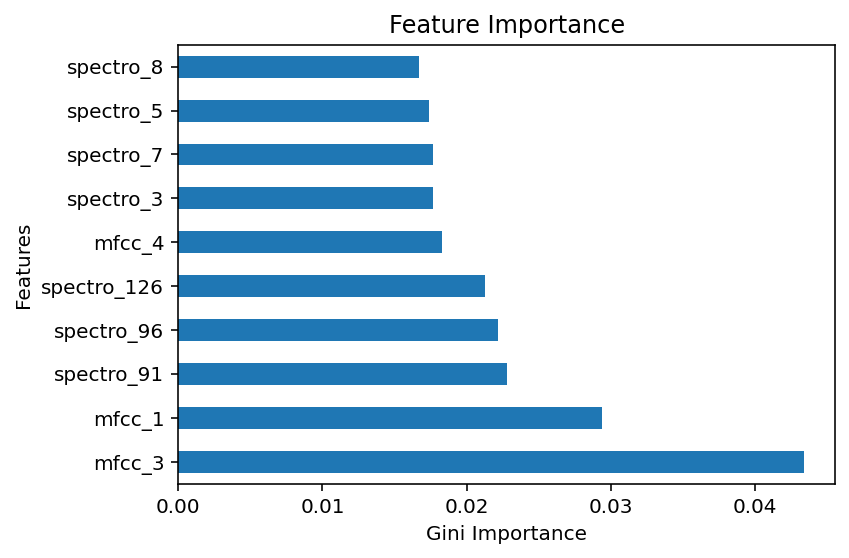

In [18]:
rf = RandomForestClassifier()
rf.fit(X_train_w, y_train_w)
scores = cross_val_score(estimator = rf, X=X_train_w, y=y_train_w, cv=5, n_jobs=1)
# save and print output
output_file = open('../output/output_file', 'a')
model_no = 'Model #: 4.1.1\n'
model_type = 'Random Forest Baseline Model (wav data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

# plots feature importants and saves plot
feat_importances = pd.Series(rf.feature_importances_, index=X_train_w.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance')
plt.ylabel('Features')
plt.xlabel('Gini Importance')
plt.tight_layout()
plt.savefig('../output/plots/4.1.1 Feature Importance.png')

#### 4.1.2 Sampling (SMOTE), no hyperparameter tuning

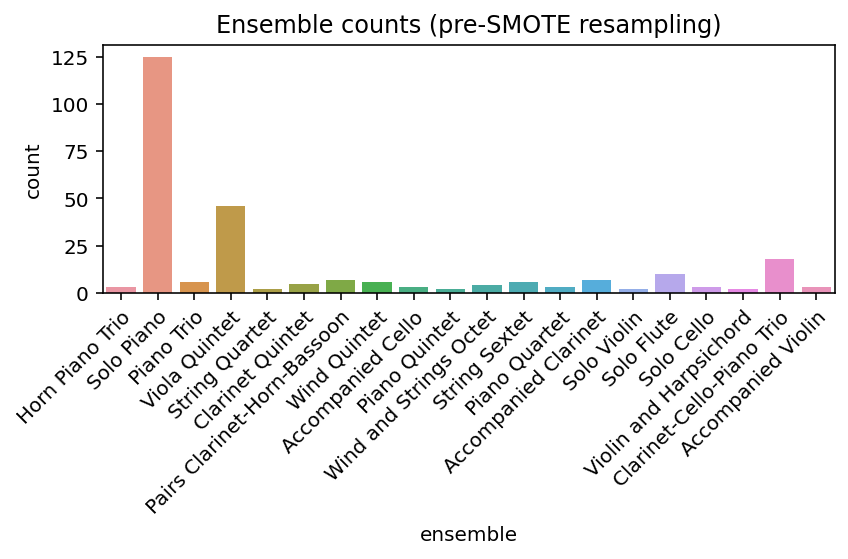

(231, 167) (231, 1)
Original dataset shape Counter({1: 125, 4: 46, 19: 18, 16: 10, 14: 7, 7: 7, 12: 6, 8: 6, 2: 6})
Resample dataset shape Counter({19: 125, 1: 125, 12: 125, 14: 125, 16: 125, 4: 125, 7: 125, 8: 125, 2: 125})


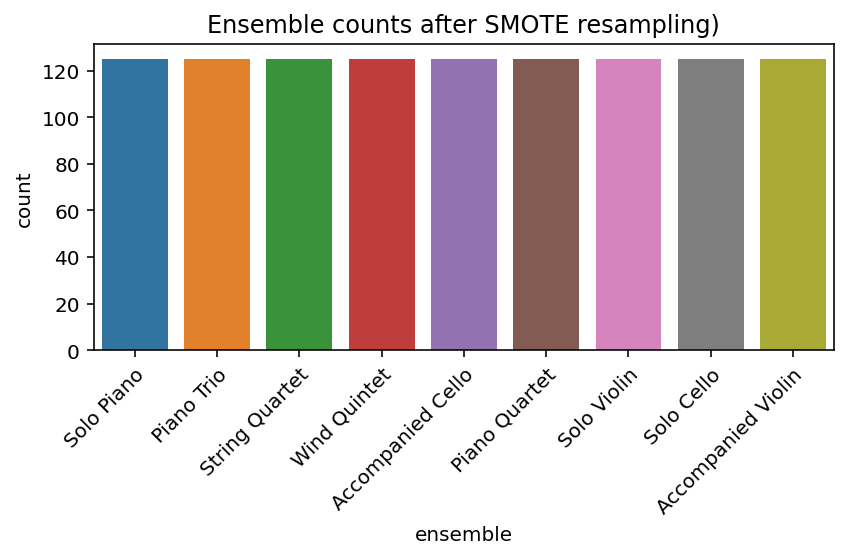

Model #: 4.1.2
 Random Forest with SMOTE and no hyperparameter tuning (wav data only)
 CV Scorese [0.99555556 0.98666667 0.99555556 1.         1.        ]
 CV Average and standard deviation: 0.9955555555555555 +/- 0.004868644955601467



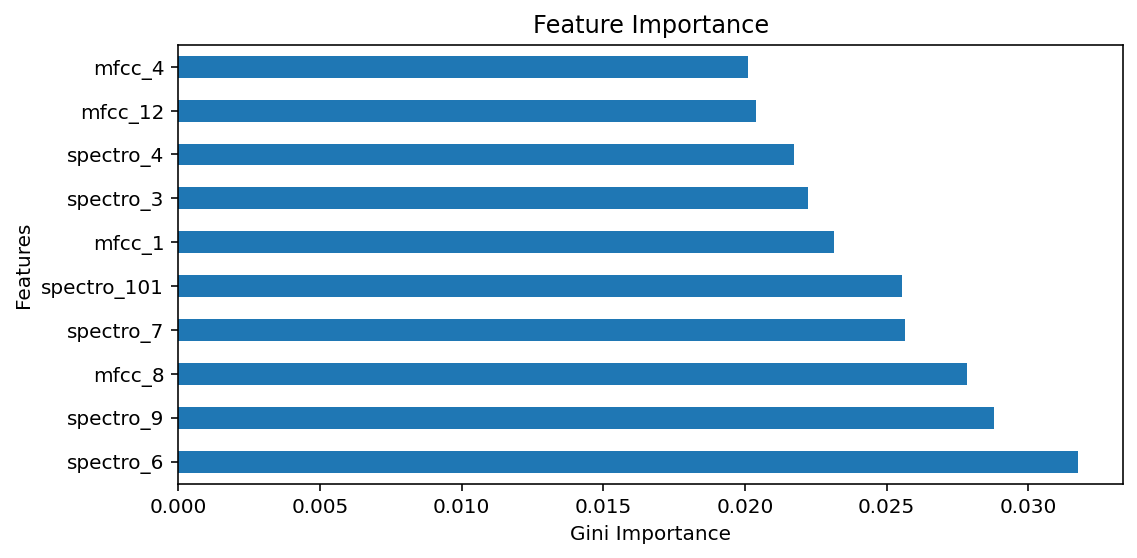

In [19]:
# todo: I think we need to re-import the data for this cell, if this is run multiple times then y_train_w gets overwritten
y_train_w = pd.read_csv('../data/y_train_w.csv',index_col = 0)
# Visualize the target variable
g = sns.countplot(y_train_w['ensemble'])
g.set_xticklabels(['Horn Piano Trio',
'Solo Piano',
'Piano Trio',
'Viola Quintet',
'String Quartet',
'Clarinet Quintet',
'Pairs Clarinet-Horn-Bassoon',
'Wind Quintet',
'Accompanied Cello',
'Piano Quintet',
'Wind and Strings Octet',
'String Sextet',
'Piano Quartet',
'Accompanied Clarinet',
'Solo Violin',
'Solo Flute',
'Solo Cello',
'Violin and Harpsichord',
'Clarinet-Cello-Piano Trio',
'Accompanied Violin'],rotation_mode='anchor',rotation=45, ha='right')
plt.title('Ensemble counts (pre-SMOTE resampling)')
plt.tight_layout()
plt.savefig('../output/plots/4.1.2 Pre-SMOTE Sample Counts.png')
plt.show()

#Drop any ensemble types with counts below 6. This because Expected n_neighbors <= n_samples,  
#but n_samples = 3, n_neighbors = 6
counts = y_train_w['ensemble'].value_counts()
X_train_w = X_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]
y_train_w = y_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]
print(X_train_w.shape, y_train_w.shape)

#Synthetic Minority Oversampling Technique (SMOTE): This technique generates synthetic data for the minority class.

#SMOTE (Synthetic Minority Oversampling Technique) works by randomly picking a point from the minority class 
#and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point 
#and its neighbors.


# Fit and apply the transform
X_SMOTE_w, y_SMOTE_w = SMOTE(random_state=101).fit_resample(X_train_w, y_train_w)

print('Original dataset shape', Counter(y_train_w.values.ravel()))
print('Resample dataset shape', Counter(y_SMOTE_w.values.ravel()))

# Visualize the target variable
g = sns.countplot(y_SMOTE_w['ensemble'])
g.set_xticklabels([
'Solo Piano', 
'Piano Trio',
'String Quartet',
'Wind Quintet',
'Accompanied Cello',
'Piano Quartet',
'Solo Violin',
'Solo Cello',
'Accompanied Violin'],rotation_mode='anchor',rotation=45, ha='right')
plt.title('Ensemble counts after SMOTE resampling)')
plt.tight_layout()
plt.savefig('../output/plots/4.1.2 Post-SMOTE Sample Counts.png')
plt.show()

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1)
rf.fit(X_SMOTE_w, y_SMOTE_w)
scores = cross_val_score(estimator = rf, X=X_SMOTE_w, y=y_SMOTE_w, cv=5, n_jobs=1)
output_file = open('../output/output_file', 'a')
model_no = 'Model #: 4.1.2\n'
model_type = 'Random Forest with SMOTE and no hyperparameter tuning (wav data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)
#Default parameters:
    #n_estimatorsint, default=100
    #max_features{“auto”, “sqrt”, “log2”}, int or float, default=”auto”
    #min_samples_splitint or float, default=2
fig, ax = plt.subplots(figsize=(8,4))
feat_importances = pd.Series(rf.feature_importances_, index=X_SMOTE_w.columns)
ax = feat_importances.nlargest(10).plot(kind='barh')
ax.set_xlabel('Gini Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance')
plt.tight_layout()
plt.savefig('../output/plots/4.1.2 Feature Importance.png')
plt.show()

#### 4.1.3 Sampling (SMOTE), hyperparameter tuning

In [20]:
#rf = RandomForestClassifier(random_state=1)

#model_params = {
#    'n_estimators': [50, 75, 100, 125, 150, 250],
#    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
#    'min_samples_split': [2, 3, 4, 5, 6]
#}
# clf = GridSearchCV(rf , model_params, cv=3) # set up grid search meta-estimator
# clf.fit(X_SMOTE_w, y_SMOTE_w)
# scores = cross_val_score(estimator = clf, X=X_SMOTE_w, y=y_SMOTE_w, cv=5, n_jobs=1)
# print('Random Forest: Sample with SMOTE, hyperparameter tuning / Only WAV data')
# print('CV Scores: ', scores)
# print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

# print(clf.best_params_)

# feat_importances = pd.Series(rf.feature_importances_, index=X_SMOTE_w.columns)
# feat_importances.nlargest(10).plot(kind='barh')

# *The above was too complex to run (Team to try on cloud or delete)

### 4.2 MIDI Data Only

#### 4.2.1 Baseline model

Model #: 4.2.1
 Random Forest Baseline midel (midi data only)
 CV Scores [0.8490566  0.86792453 0.94339623 0.92307692 0.90384615]
 CV Average and standard deviation: 0.8974600870827286 +/- 0.034705559960265774



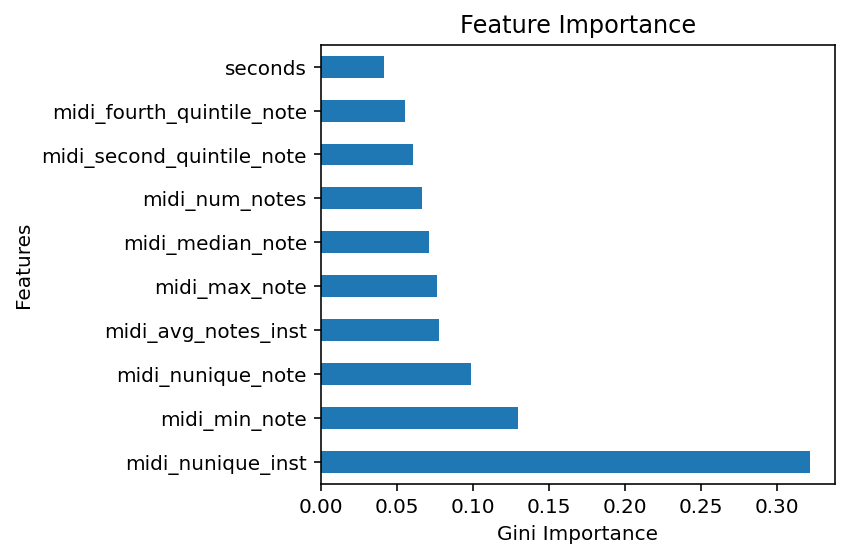

In [21]:
rf = RandomForestClassifier()
rf.fit(X_train_m, y_train_m)
scores = cross_val_score(estimator = rf, X=X_train_m, y=y_train_m, cv=5, n_jobs=1)
# print and save output
output_file = open('../output/output_file', 'a')
model_no = 'Model #: 4.2.1\n'
model_type = 'Random Forest Baseline midel (midi data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

feat_importances = pd.Series(rf.feature_importances_, index=X_train_m.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Gini Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('../output/plots/4.2.1 Feature Importance.png')

#### Observation : "midi_nunique instruments" seems to be the variable with the strongest explanatory power with 40% variance explained. We have concerns about evaluating performance using a feature set that includes this variable because in practice we typically would not have manually labelled data. 

#### 4.2.2 Sampling (SMOTE), no hyperparameter tuning

(231, 10) (231, 1)
Original dataset shape Counter({1: 125, 4: 46, 19: 18, 16: 10, 7: 7, 14: 7, 2: 6, 8: 6, 12: 6})
Resample dataset shape Counter({1: 125, 2: 125, 4: 125, 7: 125, 8: 125, 12: 125, 14: 125, 16: 125, 19: 125})
Model #: 4.2.2
 Logistic Regression with SMOTE and no hyperparameter tuning (midi data only)
 CV Scores [0.99555556 0.99555556 0.99555556 0.99555556 0.98666667]
 CV Average and standard deviation: 0.9937777777777776 +/- 0.003555555555555534



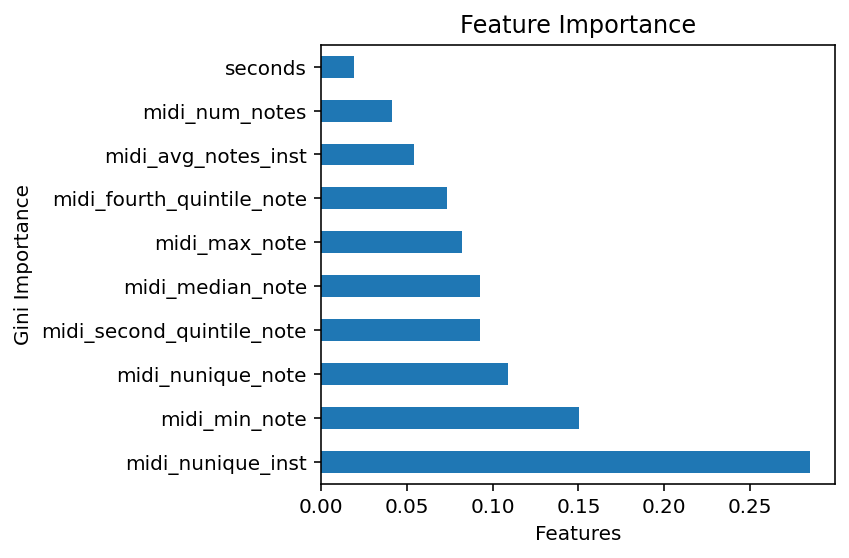

In [22]:
#Drop any ensemble types with counts below 6. This because Expected n_neighbors <= n_samples,  
#but n_samples = 3, n_neighbors = 6
counts = y_train_m['ensemble'].value_counts()
X_train_m = X_train_m[~y_train_m['ensemble'].isin(counts[counts < 6].index)]
y_train_m = y_train_m[~y_train_m['ensemble'].isin(counts[counts < 6].index)]
print(X_train_m.shape, y_train_m.shape)

#Synthetic Minority Oversampling Technique (SMOTE): This technique generates synthetic data for the minority class.

#SMOTE (Synthetic Minority Oversampling Technique) works by randomly picking a point from the minority class 
#and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point 
#and its neighbors.

# Fit and apply the transform
X_SMOTE_m, y_SMOTE_m = SMOTE(random_state=101).fit_resample(X_train_m, y_train_m)

print('Original dataset shape', Counter(y_train_m.values.ravel()))
print('Resample dataset shape', Counter(y_SMOTE_m.values.ravel()))

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1)
rf.fit(X_SMOTE_m, y_SMOTE_m)
scores = cross_val_score(estimator = rf, X=X_SMOTE_m, y=y_SMOTE_m, cv=5, n_jobs=1)
# Save and print output
output_file = open('../output/output_file', 'a')
model_no = 'Model #: 4.2.2\n'
model_type = 'Logistic Regression with SMOTE and no hyperparameter tuning (midi data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)
#Default parameters:
    #n_estimatorsint, default=100
    #max_features{“auto”, “sqrt”, “log2”}, int or float, default=”auto”
    #min_samples_splitint or float, default=2

# save and print plot 
feat_importances = pd.Series(rf.feature_importances_, index=X_train_m.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Gini Importance')
plt.tight_layout()
plt.savefig('../output/plots/4.2.2 Feature Importance.png')

#### 4.2.3 Sampling (SMOTE), hyperparameter tuning

In [23]:
# rf = RandomForestClassifier(random_state=1)

# model_params = {
#     'n_estimators': [50, 75, 100, 125, 150, 250],
#     'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
#     'min_samples_split': [2, 3, 4, 5, 6]
# }


# clf = GridSearchCV(rf , model_params, cv=3)
# clf.fit(X_SMOTE_m, y_SMOTE_m) # set up grid search meta-estimator
# clf

# scores = cross_val_score(estimator = clf, X=X_SMOTE_m, y=y_SMOTE_m, cv=5, n_jobs=1)
# print('Random Forest: Sample with SMOTE, hyperparameter tuning / Only MIDI data')
# print('CV Scores: ', scores)
# print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

# print(clf.best_params_)


# * This needs to be run in cloud or deleted

### 4.3 Combined Data (WAV & MIDI)

#### 4.3.1 Baseline model

Model #: 4.3.1
 Random Forest No SMOTE (midi and wav data)
 CV Scores [0.75471698 0.88679245 0.88679245 0.90384615 0.90384615]
 CV Average and standard deviation: 0.867198838896952 +/- 0.05675568540003608



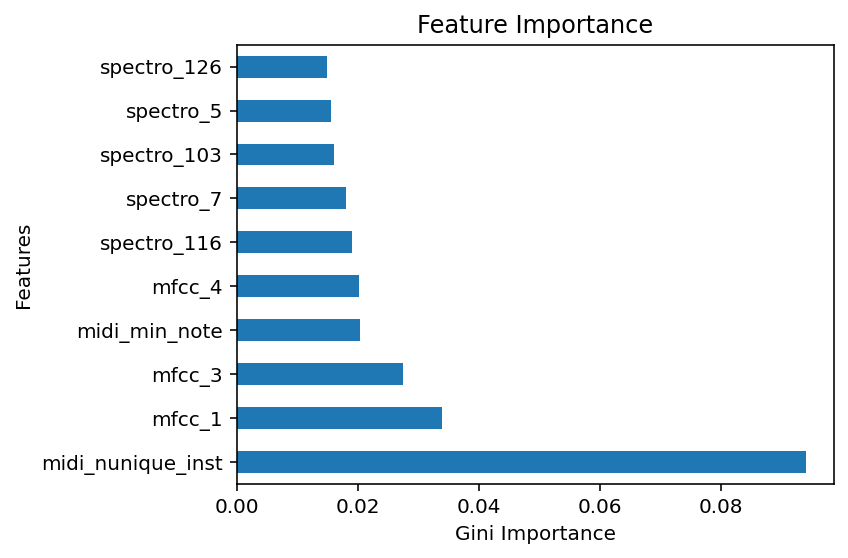

In [24]:
rf = RandomForestClassifier()
rf.fit(X_train_c, y_train_c)
scores = cross_val_score(estimator = rf, X=X_train_c, y=y_train_c, cv=5, n_jobs=1)
# prints and saves output
output_file = open('../output/output_file', 'a')
model_no = 'Model #: 4.3.1\n'
model_type = 'Random Forest No SMOTE (midi and wav data)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)
# print and save plot
feat_importances = pd.Series(rf.feature_importances_, index=X_train_c.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Gini Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('../output/plots/4.3.1 Feature Importance.png')


####  Observation : We can see here that the midi_nunique_instruments variable is still explaining far more variance in our dataset than any spectral feature. This indicates its strong predictive power in comparison.We have concerns about evaluating performance using a feature set that includes this variable because in practice we typically would not have manually labelled data. 

#### 4.3.2 Sampling (SMOTE), no hyperparameter tuning

(231, 176) (231, 1)
Original dataset shape Counter({1: 125, 4: 46, 19: 18, 16: 10, 7: 7, 14: 7, 2: 6, 8: 6, 12: 6})
Resample dataset shape Counter({1: 125, 2: 125, 4: 125, 7: 125, 8: 125, 12: 125, 16: 125, 14: 125, 19: 125})
Model #: 4.3.2
 Random Forest with SMOTE (midi and wave data)
 CV Scores [0.98666667 1.         0.98666667 0.99111111 1.        ]
 CV Average and standard deviation: 0.9928888888888888 +/- 0.006028737762778003



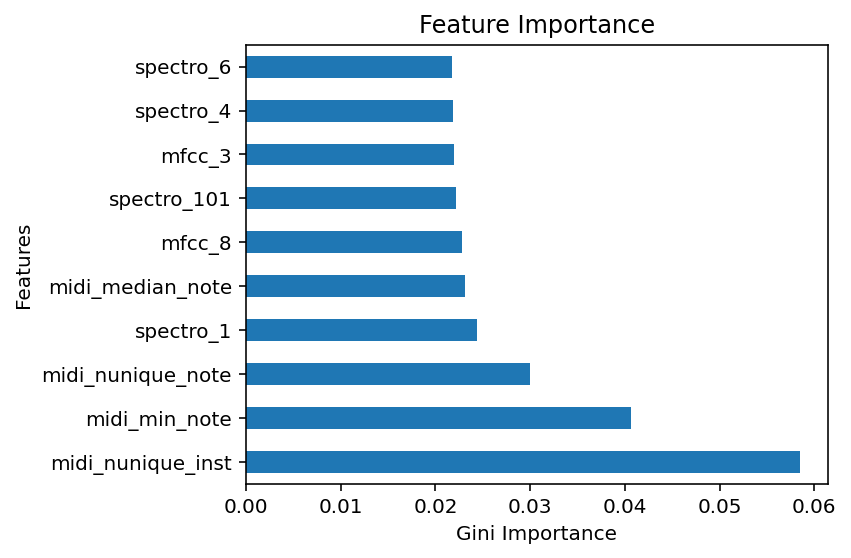

In [25]:
#Drop any ensemble types with counts below 6. This because Expected n_neighbors <= n_samples,  
#but n_samples = 3, n_neighbors = 6
counts = y_train_c['ensemble'].value_counts()
X_train_c = X_train_c[~y_train_c['ensemble'].isin(counts[counts < 6].index)]
y_train_c = y_train_c[~y_train_c['ensemble'].isin(counts[counts < 6].index)]
print(X_train_c.shape, y_train_c.shape)

#Synthetic Minority Oversampling Technique (SMOTE): This technique generates synthetic data for the minority class.

#SMOTE (Synthetic Minority Oversampling Technique) works by randomly picking a point from the minority class 
#and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point 
#and its neighbors.

X_SMOTE_c, y_SMOTE_c = SMOTE(random_state=101).fit_resample(X_train_c, y_train_c)

print('Original dataset shape', Counter(y_train_c.values.ravel()))
print('Resample dataset shape', Counter(y_SMOTE_c.values.ravel()))


from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1)
rf.fit(X_SMOTE_c, y_SMOTE_c)
scores = cross_val_score(estimator = rf, X=X_SMOTE_c, y=y_SMOTE_c, cv=5, n_jobs=1)
# prints and saves output
output_file = open('../output/output_file', 'a')
model_no = 'Model #: 4.3.2\n'
model_type = 'Random Forest with SMOTE (midi and wave data)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)
#Default parameters:
    #n_estimatorsint, default=100
    #max_features{“auto”, “sqrt”, “log2”}, int or float, default=”auto”
    #min_samples_splitint or float, default=2
    
feat_importances = pd.Series(rf.feature_importances_, index=X_SMOTE_c.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Gini Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('../output/plots/4.3.2 Feature Importance.png')

#### Observation : 

- Midi_min_note variable also has strong predictive power. Certain ensembles will have instruments that allow for lower notes to be played so the lowest note would probably be a good predictor of the ensemble. 

- Midi_nunique_note is important because ensembles composed of instruments with larger ranges will typically have a higher possibility of playing unique notes due to their unique access to notes that other ensembles might not have access to.

#### 4.3.3 Sampling (SMOTE), hyperparameter tuning

In [26]:
# rf = RandomForestClassifier(random_state=1)

# model_params = {
#     'n_estimators': [50, 75, 100, 125, 150, 250],
#     'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
#     'min_samples_split': [2, 3, 4, 5, 6]
# }
# clf = GridSearchCV(rf , model_params, cv=3) # set up grid search meta-estimator
# clf.fit(X_SMOTE_c, y_SMOTE_c)
# scores = cross_val_score(estimator = clf, X=X_SMOTE_c, y=y_SMOTE_c, cv=5, n_jobs=1)
# print('Random Forest: Sample with SMOTE, hyperparameter tuning / Both MIDI & WAV data')
# print('CV Scores: ', scores)
# print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

# print(clf.best_params_)

# * This needs to be run on cloud or deleted.

## 5. SVM

### 5.1 Spectral (WAV) Data Only

#### 5.1.1 Baseline model

In [27]:
#Create baseline SVM model with Spectral Data

svm = make_pipeline(SVC())
svm.fit(X_train_w, y_train_w.values.ravel())

#Apply 5 fold cross validation scoring to make sure results are reliable

scores = cross_val_score(estimator = svm, X=X_train_w, y=y_train_w.values.ravel(), cv=5,n_jobs=1)
# prints and saves output
output_file = open('../output/output_file', 'a')
model_no = 'Model #: 5.1.1\n'
model_type = 'SVM Baseline Model (wav data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 5.1.1
 SVM Baseline Model (wav data only)
 CV Scores [0.57446809 0.67391304 0.65217391 0.67391304 0.67391304]
 CV Average and standard deviation: 0.6496762257169288 +/- 0.03853510830830736



#### 5.1.2 Hyperparameter tuning

In [28]:
#Find best hyperparameters
param_grid = {'C': np.logspace(-4, 4, 20), 
              'gamma': np.logspace(-3, 2, 6),                     
              'kernel': ['linear','rbf','poly']} 
  
grid = GridSearchCV(SVC(), param_grid, cv=5)
  
# fitting the model for grid search
grid.fit(X_train_w, y_train_w.values.ravel())

print(grid.best_params_)


#Create Model with best hyperparameters

svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(X_train_w, y_train_w.values.ravel())

#Apply 5 fold cross validation scoring to make sure results are reliable

scores = cross_val_score(estimator = svm, X=X_train_w, y=y_train_w.values.ravel(), cv=5, n_jobs=1)
output_file = open('../output/output_file', 'a')
model_no = 'Model #: 5.1.2\n'
model_type = 'SVM with hyperparameter tuning (wav data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

{'C': 0.0018329807108324356, 'gamma': 0.001, 'kernel': 'linear'}
Model #: 5.1.2
 SVM with hyperparameter tuning (wav data only)
 CV Scores [0.89361702 0.89130435 0.91304348 0.91304348 0.95652174]
 CV Average and standard deviation: 0.9135060129509712 +/- 0.023406266253149247



#### 5.1.3 Hyperparameter tuning, PCA

    Number of PCA Components  Explained Fraction of Total Variance
0                          1                              0.861122
1                          2                              0.952000
2                          3                              0.972518
3                          4                              0.979182
4                          5                              0.985610
5                          6                              0.988322
6                          7                              0.990523
7                          8                              0.992320
8                          9                              0.993631
9                         10                              0.994591
10                        11                              0.995296
11                        12                              0.995868
12                        13                              0.996329
13                        14                              0.99

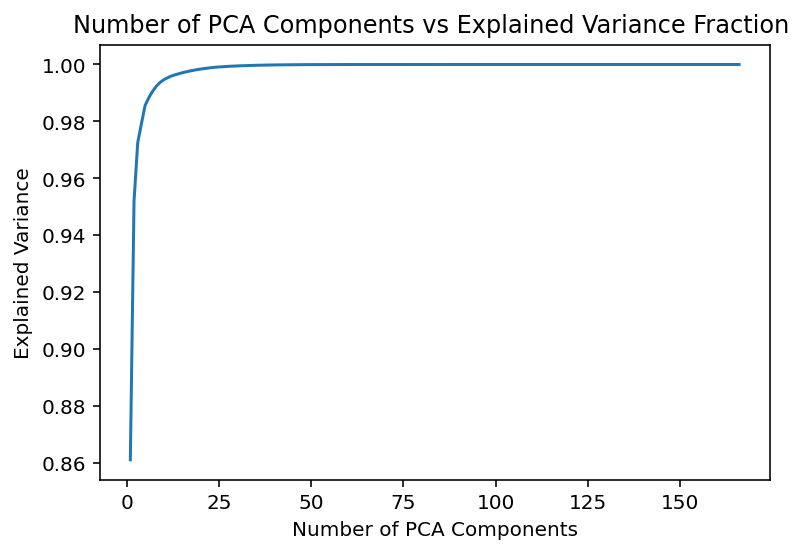

{'C': 0.0018329807108324356, 'gamma': 0.001, 'kernel': 'linear'}
Model #: 5.1.3
 SVM with hyperparameter tuning and PCA (wav data only)
 CV Scores [0.91489362 0.86956522 0.86956522 0.93478261 0.93478261]
 CV Average and standard deviation: 0.904717853839038 +/- 0.029606556111681368



In [29]:
# Create list of K dimensions to test for PCA
p_comp = np.arange(1,25)


# Create empty list to store fraction of total variance
fraction_total_variance = []

# Write for loop to try k values for PCA
for i in p_comp:
    pca=PCA(n_components = i)
    pca.fit(X_train_w)
    train_pca_w = pca.transform(X_train_w)
    
    #Append fractions of explained total variance
    fraction_total_variance.append(np.sum(pca.explained_variance_ratio_))
    

#Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].    
variance_pca_df = pd.DataFrame({'Number of PCA Components':p_comp , 'Explained Fraction of Total Variance' :fraction_total_variance })

pd.set_option("display.max_rows", 500, "display.max_columns", 5, 'display.width', 1000)  
print(variance_pca_df)


#all possible values of k can go up to 166 i.e. one less than 167
all_possible_k = np.arange(1,167)

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca=PCA(n_components = i)
    pca.fit(X_train_w)
    train_pca_w = pca.transform(X_train_w)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    


plt.plot(all_possible_k, all_possible_k_variance)

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')
plt.savefig('../output/plots/5.1.3 PCA Plot.png')
plt.show()

#Perform PCA with 15 components
pca=PCA(n_components = 15)
pca.fit(X_train_w)
train_pca_w = pca.transform(X_train_w)

from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': np.logspace(-4, 4, 20), 
              'gamma': np.logspace(-3, 2, 6),
              'kernel': ['linear','rbf','poly']} 
  
grid = GridSearchCV(SVC(), param_grid , cv=5)
  
# fitting the model for grid search
grid.fit(train_pca_w, y_train_w.values.ravel())

print(grid.best_params_)

#Create Model with best hyperparameters and PCA
svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_w, y_train_w.values.ravel())


#Apply 5 fold cross validation scoring to make sure results are reliable
scores = cross_val_score(estimator = svm, X=train_pca_w, y=y_train_w.values.ravel(), cv=5, n_jobs=1)
output_file = open('../output/output_file', 'a')
model_no = 'Model #: 5.1.3\n'
model_type = 'SVM with hyperparameter tuning and PCA (wav data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)


#### Observation : PCA does not reduce score but reduces number of features to just 15 principal components

 #### 5.1.4 Hyperparameter tuning, PCA, SMOTE

Before oversampling:  Counter({1: 125, 4: 46, 19: 18, 16: 10, 14: 7, 7: 7, 12: 6, 8: 6, 2: 6})
(231, 167) (231, 1)
After oversampling:  Counter({19: 125, 1: 125, 12: 125, 14: 125, 16: 125, 4: 125, 7: 125, 8: 125, 2: 125})
    Number of PCA Components  Explained Fraction of Total Variance
0                          1                              0.794009
1                          2                              0.925616
2                          3                              0.965930
3                          4                              0.978757
4                          5                              0.984324
5                          6                              0.988645
6                          7                              0.991314
7                          8                              0.992466
8                          9                              0.993562
9                         10                              0.994452
10                        11             

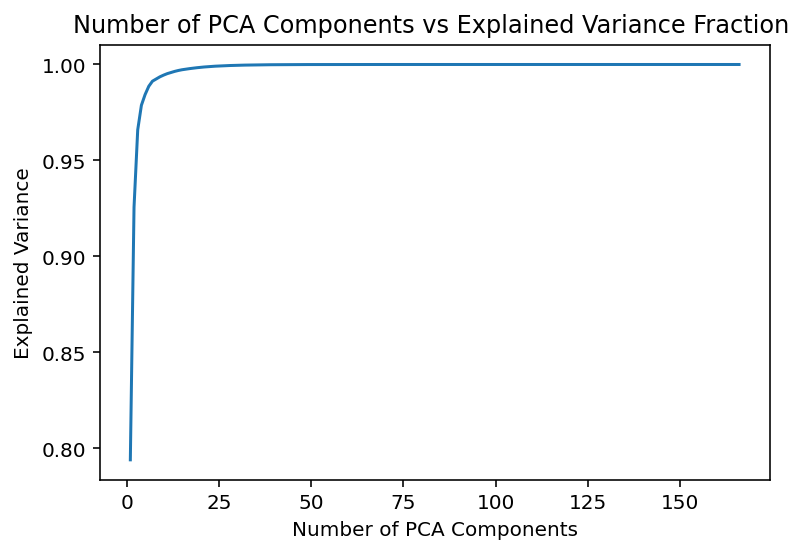

{'C': 0.03359818286283781, 'gamma': 0.001, 'kernel': 'linear'}
Model #: 1.1.2
 SVM with Hyperparameter tuning, PCA, SMOTE (wav data only)
 CV Scores [1.         0.98222222 0.99111111 1.         0.99555556]
 CV Average and standard deviation: 0.9937777777777776 +/- 0.00665183535426478



In [30]:
print("Before oversampling: ",Counter(y_train_w.values.ravel()))

#Drop any ensemble types with counts below 6
counts = y_train_w['ensemble'].value_counts()
X_train_w_smote = X_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]
y_train_w_smote = y_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]

#Now print data shape
print(X_train_w_smote.shape, y_train_w_smote.shape)

# fit and apply the transform
X_SMOTE, y_SMOTE = SMOTE().fit_resample(X_train_w_smote, y_train_w_smote.values.ravel())

# summarize class distribution
print("After oversampling: ",Counter(y_SMOTE))

# Create list of K dimensions to test for PCA
p_comp = np.arange(1,25)


# Create empty list to store fraction of total variance
fraction_total_variance = []

# Write for loop to try k values for PCA
for i in p_comp:
    pca=PCA(n_components = i)
    pca.fit(X_SMOTE)
    train_pca_w_smote = pca.transform(X_SMOTE)
    
    #Append fractions of explained total variance
    fraction_total_variance.append(np.sum(pca.explained_variance_ratio_))
    

#Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].    
variance_pca_df = pd.DataFrame({'Number of PCA Components':p_comp , 'Explained Fraction of Total Variance' :fraction_total_variance })

pd.set_option("display.max_rows", 500, "display.max_columns", 5, 'display.width', 1000)  
print(variance_pca_df)


#all possible values of k can go up to 166 i.e. one less than 167
all_possible_k = np.arange(1,167)

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca=PCA(n_components = i)
    pca.fit(X_SMOTE)
    train_pca_w_smote = pca.transform(X_SMOTE)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    

plt.plot(all_possible_k, all_possible_k_variance)

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')
plt.savefig('../output/plots/5.1.4 PCA Plot.png')
plt.show()

#Perform PCA with 15 components
pca=PCA(n_components = 15)
pca.fit(X_SMOTE)
train_pca_w_smote = pca.transform(X_SMOTE)


from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': np.logspace(-4, 4, 20), 
              'gamma': np.logspace(-3, 2, 6),
              'kernel': ['linear','rbf','poly']} 
  
grid = GridSearchCV(SVC(), param_grid , cv=5)
  
# fitting the model for grid search
grid.fit(train_pca_w_smote, y_SMOTE)

print(grid.best_params_)

#Create SVM model with best hyperparameters, PCA and SMOTE

svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_w_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_w_smote, y=y_SMOTE, cv=5, n_jobs=1)

#print and save output
output_file = open('../output/output_file', 'a')
model_no = 'Model #: 5.1.4\n'
model_type = 'SVM with Hyperparameter tuning, PCA, SMOTE (wav data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

#### 5.1.5 Hyperparameter tuning, PCA, SMOTE, Min Max Scaler

In [31]:
#### MinMaxScaler Application

#Create SVM model with best hyperparameters, PCA and SMOTE and MinMaxScaler

svm = make_pipeline(MinMaxScaler() ,SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_w_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_w_smote, y=y_SMOTE, cv=5, n_jobs=1)

#Apply 5 fold cross validation scoring to make sure results are reliable
# Print and save output
output_file = open('../output/output_file', 'a')
model_no = 'Model #: 5.1.5\n'
model_type = 'SVM with Hyperparameter tuning, PCA, SMOTE, and Min Max Scaler (wav data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 5.1.5
 SVM with Hyperparameter tuning, PCA, SMOTE, and Min Max Scaler (wav data only)
 CV Scores [0.73777778 0.69333333 0.72444444 0.77333333 0.72      ]
 CV Average and standard deviation: 0.7297777777777779 +/- 0.02612789058968722



#### 5.1.6 Hyperparameter tuning, PCA, SMOTE, Standard Scaler

In [32]:
#### Standard Scaler Application

#Create SVM model with best hyperparameters, PCA and SMOTE and StandardScaler

svm = make_pipeline(StandardScaler() ,SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_w_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_w_smote, y=y_SMOTE, cv=5, n_jobs=1)

#Apply 5 fold cross validation scoring to make sure results are reliable
# Print and save output
output_file = open('../output/output_file', 'a')
model_no = 'Model #: 5.1.6\n'
model_type = 'SVM with Hyperparameter tuning, PCA, SMOTE, and Standard Scaler (wav data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 5.1.5
 SVM with Hyperparameter tuning, PCA, SMOTE, and Standard Scaler (wav data only)
 CV Scores [0.97333333 0.94666667 0.96888889 0.98666667 0.98666667]
 CV Average and standard deviation: 0.9724444444444444 +/- 0.014713729206441655



### 5.2 MIDI Data Only

#### 5.2.1 Baseline model

In [33]:
#Create baseline SVM model with MIDI Data only

svm = make_pipeline(SVC())
svm.fit(X_train_m, y_train_m.values.ravel())

#Apply 5 fold cross validation scoring to make sure results are reliable

scores = cross_val_score(estimator = svm, X=X_train_m, y=y_train_m.values.ravel(), cv=5,n_jobs=1)
# Print and save output
output_file = open('../output/output_file', 'a')
model_no = 'Model #: 5.2.1\n'
model_type = 'SVM Baseline Model (midi data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 5.2.1
 SVM Baseline Model (midi data only)
 CV Scores [0.70212766 0.73913043 0.73913043 0.73913043 0.73913043]
 CV Average and standard deviation: 0.7317298797409805 +/- 0.01480111008325622



#### 5.2.2 Hyperparameter tuning

#### This model with C = 545 could not complete running after 2 hours. This is possibly because of the features makes the calculation complex.

In [34]:
# #Find best hyperparameters
# param_grid = {'C': np.logspace(-4, 4, 20)}
# grid = GridSearchCV(SVC(), param_grid)
  
# # fitting the model for grid search
# grid.fit(X_train_m, y_train_m.values.ravel())

# print(grid.best_params_)

# #Create Model with best hyperparameters

# svm = make_pipeline(SVC(kernel='linear', C = 545.559 ))
# svm.fit(X_train_m, y_train_m.values.ravel())

# #Apply 5 fold cross validation scoring to make sure results are reliable

# scores = cross_val_score(estimator = svm, X=X_train_m, y=y_train_m.values.ravel(), cv=5, n_jobs=1)
# print('SVM with hyperparameter tuning')
# print('CV Scores: ', scores)
# print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

# The cell above could not run. Team to try running in cloud or delete cell

#### 5.2.3 SMOTE, PCA

In [35]:
# print("Before oversampling: ",Counter(y_train_m.values.ravel()))

# #Drop any ensemble types with counts below 6
# counts = y_train_m['ensemble'].value_counts()
# X_train_m_smote = X_train_m[~y_train_m['ensemble'].isin(counts[counts < 6].index)]
# y_train_m_smote = y_train_m[~y_train_m['ensemble'].isin(counts[counts < 6].index)]

# #Now print data shape
# print(X_train_m_smote.shape, y_train_m_smote.shape)


# # fit and apply the transform
# X_SMOTE, y_SMOTE = SMOTE().fit_resample(X_train_m_smote, y_train_m_smote.values.ravel())

# # summarize class distribution
# print("After oversampling: ",Counter(y_SMOTE))

# # Create list of K dimensions to test for PCA
# p_comp = np.arange(1,10)


# # Create empty list to store fraction of total variance
# fraction_total_variance = []

# # Write for loop to try k values for PCA
# for i in p_comp:
#     pca=PCA(n_components = i)
#     pca.fit(X_SMOTE)
#     train_pca_m_smote = pca.transform(X_SMOTE)
    
#     #Append fractions of explained total variance
#     fraction_total_variance.append(np.sum(pca.explained_variance_ratio_))
    

# #Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].    
# variance_pca_df = pd.DataFrame({'Number of PCA Components':p_comp , 'Explained Fraction of Total Variance' :fraction_total_variance })

# pd.set_option("display.max_rows", 500, "display.max_columns", 5, 'display.width', 1000)  
# print(variance_pca_df)


# #all possible values of k can go up to 9 i.e. one less than 10
# all_possible_k = np.arange(1,10)

# # Create empty list to store fraction of total variance
# all_possible_k_variance = []

# # Write for loop to try k values for PCA
# for i in all_possible_k:
#     pca=PCA(n_components = i)
#     pca.fit(X_SMOTE)
#     train_pca_m_smote = pca.transform(X_SMOTE)
    
#     #Append fractions of explained total variance
#     all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    

# plt.plot(all_possible_k, all_possible_k_variance)

# # show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# # Add title and axis names
# plt.title('Number of PCA Components vs Explained Variance Fraction ')
# plt.xlabel('Number of PCA Components')
# plt.ylabel('Explained Variance')

# plt.show()

# #Perform PCA with 2 components
# pca=PCA(n_components = 2)
# pca.fit(X_SMOTE)
# train_pca_m_smote = pca.transform(X_SMOTE)

# from sklearn.model_selection import GridSearchCV
  
# # defining parameter range
# param_grid = {'C': np.logspace(-4, 4, 20)} 
  
# grid = GridSearchCV(SVC(), param_grid , cv=5)
  
# # fitting the model for grid search
# grid.fit(train_pca_m_smote, y_SMOTE)

# print(grid.best_params_)

# #Create SVM model with best hyperparameters and SMOTE

# svm = make_pipeline(SVC(kernel='linear', C = grid.best_params_['C'] ))
# svm.fit(train_pca_m_smote, y_SMOTE)
# scores = cross_val_score(estimator = svm, X=train_pca_m_smote, y=y_SMOTE, cv=5, n_jobs=1)

# #Apply 5 fold cross validation scoring to make sure results are reliable
# print('SVM with hyperparameter and SMOTE tuning')
# print('CV Scores: ', scores)
# print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

# #### MinMaxScaler Application

# #Create SVM model with best hyperparameters,SMOTE and MinMaxScaler

# svm = make_pipeline(MinMaxScaler() ,SVC(kernel='linear', C = grid.best_params_['C'] ))
# svm.fit(train_pca_m_smote, y_SMOTE)
# scores = cross_val_score(estimator = svm, X=train_pca_m_smote, y=y_SMOTE, cv=5, n_jobs=1)

# #Apply 5 fold cross validation scoring to make sure results are reliable
# print('SVM with hyperparameter tuning and MinMaxScaler')
# print('CV Scores: ', scores)
# print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

# #### StandardScaler Application

# #Create SVM model with best hyperparameters,  SMOTE and StandardScaler

# svm = make_pipeline(MinMaxScaler() ,SVC(kernel='linear', C = grid.best_params_['C']))
# svm.fit(train_pca_m_smote, y_SMOTE)
# scores = cross_val_score(estimator = svm, X=train_pca_m_smote, y=y_SMOTE, cv=5, n_jobs=1)

# #Apply 5 fold cross validation scoring to make sure results are reliable
# print('SVM with hyperparameter tuning and StandardScaler')
# print('CV Scores: ', scores)
# print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

# The cell above could not run. Team to try running in cloud or delete cell

#### Models on MIDI Data could not be run due to long runtime (4 hours) for linear, rbf and polynomial kernels.

#### One clue we have here on why the SVM model struggles with classifying the MIDI data is that the best C value is extremely high at 10,000. In other words, very low regularization strength and extreme overfitting is required to fit the model well

### 5.3 Combined Data (WAV & MIDI)

#### 5.3.1 Baseline model

In [36]:
#Create baseline SVM model with Spectral Wav and MIDI Data

svm = make_pipeline(SVC())
svm.fit(X_train_c, y_train_c.values.ravel())

#Apply 5 fold cross validation scoring to make sure results are reliable

scores = cross_val_score(estimator = svm, X=X_train_c, y=y_train_c.values.ravel(), cv=5,n_jobs=1)
output_file = open('../output/output_file', 'a')
model_no = 'Model #: 5.3.1\n'
model_type = 'SVM with Baseline Model (midi and wav data)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 5.3.1
 SVM with Baseline Model (midi and wav data)
 CV Scores [0.70212766 0.73913043 0.73913043 0.73913043 0.73913043]
 CV Average and standard deviation: 0.7317298797409805 +/- 0.01480111008325622



#### 5.3.2 Hyperparameter tuning

In [37]:
# #Find best hyperparameters
# param_grid = {'C': np.logspace(-4, 4, 20), 
#               'gamma': np.logspace(-3, 2, 6),                     
#               'kernel': ['linear','rbf','poly']} 
  
# grid = GridSearchCV(SVC(), param_grid, cv=5)
  
# # fitting the model for grid search
# grid.fit(X_train_c, y_train_c.values.ravel())

# print(grid.best_params_)


# #Create Model with best hyperparameters

# svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
# svm.fit(X_train_c, y_train_c.values.ravel())

# #Apply 5 fold cross validation scoring to make sure results are reliable

# scores = cross_val_score(estimator = svm, X=X_train_c, y=y_train_c.values.ravel(), cv=5, n_jobs=1)
# print('SVM with hyperparameter tuning')
# print('CV Scores: ', scores)
# print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

# The cell above could not run. Team to try running in cloud or delete cell

#### 5.3.2 Hyperparameter tuning, PCA

In [38]:
# # Create list of K dimensions to test for PCA
# p_comp = np.arange(1,25)


# # Create empty list to store fraction of total variance
# fraction_total_variance = []

# # Write for loop to try k values for PCA
# for i in p_comp:
#     pca=PCA(n_components = i)
#     pca.fit(X_train_w)
#     train_pca_w = pca.transform(X_train_w)
    
#     #Append fractions of explained total variance
#     fraction_total_variance.append(np.sum(pca.explained_variance_ratio_))
    

# #Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].    
# variance_pca_df = pd.DataFrame({'Number of PCA Components':p_comp , 'Explained Fraction of Total Variance' :fraction_total_variance })

# pd.set_option("display.max_rows", 500, "display.max_columns", 5, 'display.width', 1000)  
# print(variance_pca_df)


# #all possible values of k can go up to 175 i.e. one less than 176
# all_possible_k = np.arange(1,176)

# # Create empty list to store fraction of total variance
# all_possible_k_variance = []

# # Write for loop to try k values for PCA
# for i in all_possible_k:
#     pca=PCA(n_components = i)
#     pca.fit(X_train_w)
#     train_pca_w = pca.transform(X_train_w)
    
#     #Append fractions of explained total variance
#     all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    


# plt.plot(all_possible_k, all_possible_k_variance)

# # show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# # Add title and axis names
# plt.title('Number of PCA Components vs Explained Variance Fraction ')
# plt.xlabel('Number of PCA Components')
# plt.ylabel('Explained Variance')

# plt.show()


# #Perform PCA with 15 components
# pca=PCA(n_components = 15)
# pca.fit(X_train_c)
# train_pca_c = pca.transform(X_train_c)

# from sklearn.model_selection import GridSearchCV
  
# # defining parameter range
# param_grid = {'C': np.logspace(-4, 4, 20), 
#               'gamma': np.logspace(-3, 2, 6),
#               'kernel': ['linear','rbf','poly']} 
  
# grid = GridSearchCV(SVC(), param_grid , cv=5)
  
# # fitting the model for grid search
# grid.fit(train_pca_c, y_train_c.values.ravel())

# print(grid.best_params_)

# #Create Model with best hyperparameters and PCA
# svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
# svm.fit(train_pca_c, y_train_c.values.ravel())


# #Apply 5 fold cross validation scoring to make sure results are reliable
# scores = cross_val_score(estimator = svm, X=train_pca_c, y=y_train_c.values.ravel(), cv=5, n_jobs=1)
# print('SVM with hyperparameter tuning and PCA')
# print('CV Scores: ', scores)
# print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

# #### Note the models could not complete the run when midi features were added.

# The cell above could not run. Team to try running in cloud or delete cell

## 6. Neural Network

### 6.1 Spectral (WAV) Data Only

#### 6.1.1 Baseline model

Epoch 1/200
8/8 [==============================] - 1s 2ms/step - loss: 11.4955 - accuracy: 0.1775
Epoch 2/200
8/8 [==============================] - 0s 2ms/step - loss: 2.3411 - accuracy: 0.4848
Epoch 3/200
8/8 [==============================] - 0s 2ms/step - loss: 1.4237 - accuracy: 0.5714
Epoch 4/200
8/8 [==============================] - 0s 2ms/step - loss: 1.2883 - accuracy: 0.6580
Epoch 5/200
8/8 [==============================] - 0s 2ms/step - loss: 1.0968 - accuracy: 0.6104
Epoch 6/200
8/8 [==============================] - 0s 2ms/step - loss: 1.0041 - accuracy: 0.6710
Epoch 7/200
8/8 [==============================] - 0s 2ms/step - loss: 0.8956 - accuracy: 0.7403
Epoch 8/200
8/8 [==============================] - 0s 2ms/step - loss: 0.7355 - accuracy: 0.8009
Epoch 9/200
8/8 [==============================] - 0s 2ms/step - loss: 0.6801 - accuracy: 0.8009
Epoch 10/200
8/8 [==============================] - 0s 2ms/step - loss: 0.5883 - accuracy: 0.8442
Epoch 11/200
8/8 [==========

8/8 [==============================] - 0s 2ms/step - loss: 2.5395e-04 - accuracy: 1.0000
Epoch 165/200
8/8 [==============================] - 0s 2ms/step - loss: 2.5432e-04 - accuracy: 1.0000
Epoch 166/200
8/8 [==============================] - 0s 2ms/step - loss: 2.4192e-04 - accuracy: 1.0000
Epoch 167/200
8/8 [==============================] - 0s 2ms/step - loss: 2.3097e-04 - accuracy: 1.0000
Epoch 168/200
8/8 [==============================] - 0s 2ms/step - loss: 2.2409e-04 - accuracy: 1.0000
Epoch 169/200
8/8 [==============================] - 0s 3ms/step - loss: 2.2073e-04 - accuracy: 1.0000
Epoch 170/200
8/8 [==============================] - 0s 4ms/step - loss: 2.1631e-04 - accuracy: 1.0000
Epoch 171/200
8/8 [==============================] - 0s 3ms/step - loss: 2.1121e-04 - accuracy: 1.0000
Epoch 172/200
8/8 [==============================] - 0s 3ms/step - loss: 2.0837e-04 - accuracy: 1.0000
Epoch 173/200
8/8 [==============================] - 0s 2ms/step - loss: 2.0533e-04 - a

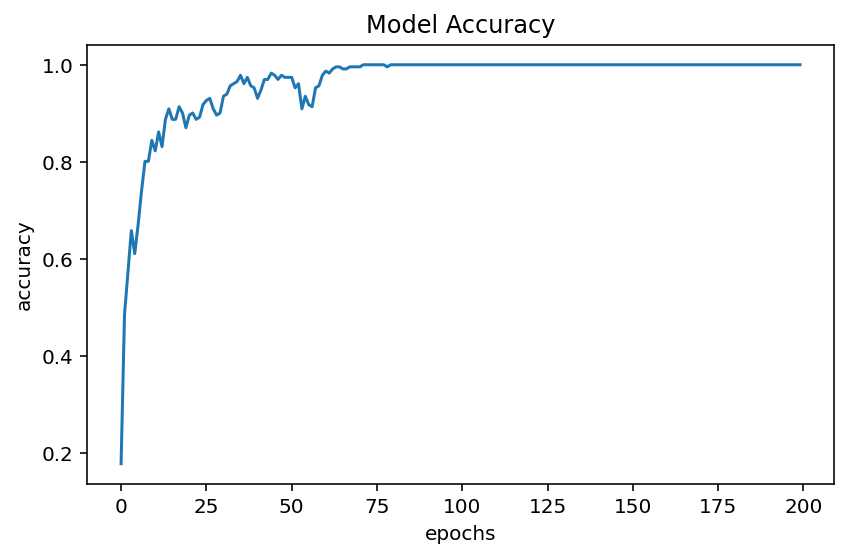

In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(176, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(90, activation='relu'),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dense(70, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(21)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(X_train_w, y_train_w, epochs=200)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.tight_layout()
#plt.savefig('../output/plots/6.1.1 Accuracy Plot.png')

scores = model.history.history['accuracy'][-1]
output_file = open('../output/output_file', 'a')
model_no = 'Model#: 6.1.1\n'
model_type = 'Neural Network (wav data only)\n'
model_scores = f'Accuracy Score {scores}\n'
output_file.writelines([model_no, model_type, model_scores])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)
pass

#### observation: only using the wave features has the strongest performance in a neral network

### 6.2 MIDI Data Only

#### 6.2.1 Baseline model

Epoch 1/200
8/8 [==============================] - 1s 2ms/step - loss: 2393.1372 - accuracy: 0.3247
Epoch 2/200
8/8 [==============================] - 0s 2ms/step - loss: 281.8351 - accuracy: 0.6797
Epoch 3/200
8/8 [==============================] - 0s 3ms/step - loss: 221.1717 - accuracy: 0.6667
Epoch 4/200
8/8 [==============================] - 0s 4ms/step - loss: 177.7626 - accuracy: 0.7186
Epoch 5/200
8/8 [==============================] - 0s 3ms/step - loss: 165.7333 - accuracy: 0.7100
Epoch 6/200
8/8 [==============================] - 0s 3ms/step - loss: 150.5645 - accuracy: 0.7359
Epoch 7/200
8/8 [==============================] - 0s 4ms/step - loss: 148.0435 - accuracy: 0.6667
Epoch 8/200
8/8 [==============================] - 0s 5ms/step - loss: 245.1354 - accuracy: 0.6017
Epoch 9/200
8/8 [==============================] - 0s 4ms/step - loss: 258.4416 - accuracy: 0.7446
Epoch 10/200
8/8 [==============================] - 0s 7ms/step - loss: 215.2855 - accuracy: 0.7013
Epoch 11

8/8 [==============================] - 0s 3ms/step - loss: 6.0839 - accuracy: 0.8528
Epoch 166/200
8/8 [==============================] - 0s 3ms/step - loss: 5.1623 - accuracy: 0.7403
Epoch 167/200
8/8 [==============================] - 0s 2ms/step - loss: 7.5680 - accuracy: 0.7965
Epoch 168/200
8/8 [==============================] - 0s 3ms/step - loss: 6.5051 - accuracy: 0.8355
Epoch 169/200
8/8 [==============================] - 0s 3ms/step - loss: 4.9097 - accuracy: 0.8268
Epoch 170/200
8/8 [==============================] - 0s 3ms/step - loss: 3.2015 - accuracy: 0.7835
Epoch 171/200
8/8 [==============================] - 0s 2ms/step - loss: 4.9303 - accuracy: 0.8355
Epoch 172/200
8/8 [==============================] - 0s 2ms/step - loss: 6.7064 - accuracy: 0.8095
Epoch 173/200
8/8 [==============================] - 0s 3ms/step - loss: 9.5004 - accuracy: 0.8139
Epoch 174/200
8/8 [==============================] - 0s 2ms/step - loss: 8.5806 - accuracy: 0.8355
Epoch 175/200
8/8 [=====

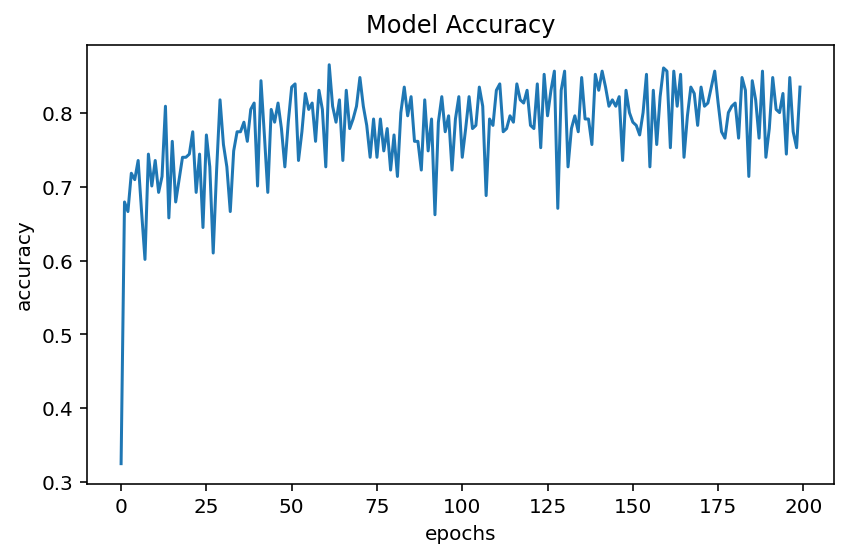

In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(176, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(90, activation='relu'),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dense(70, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(21)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(X_train_m, y_train_m, epochs=200)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.tight_layout()
plt.savefig('../output/plots/6.2.1 Accuracy Plot.png')

scores = model.history.history['accuracy'][-1]
output_file = open('../output/output_file', 'a')
model_no = 'Model#: 6.2.1\n'
model_type = 'Neural Network (midi data only)\n'
model_scores = f'Accuracy Score {scores}\n'
output_file.writelines([model_no, model_type, model_scores])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)
pass

### 6.3 Combined Data (WAV & MIDI)

#### 6.3.1 Baseline model

Epoch 1/200
8/8 [==============================] - 1s 3ms/step - loss: 3361.1719 - accuracy: 0.2554 
Epoch 2/200
8/8 [==============================] - 0s 2ms/step - loss: 651.1790 - accuracy: 0.5931
Epoch 3/200
8/8 [==============================] - 0s 2ms/step - loss: 223.8900 - accuracy: 0.6537
Epoch 4/200
8/8 [==============================] - 0s 3ms/step - loss: 137.4361 - accuracy: 0.7662
Epoch 5/200
8/8 [==============================] - 0s 2ms/step - loss: 154.8956 - accuracy: 0.5887
Epoch 6/200
8/8 [==============================] - 0s 2ms/step - loss: 116.8686 - accuracy: 0.7662
Epoch 7/200
8/8 [==============================] - 0s 3ms/step - loss: 90.5921 - accuracy: 0.7359
Epoch 8/200
8/8 [==============================] - 0s 2ms/step - loss: 168.4749 - accuracy: 0.6797
Epoch 9/200
8/8 [==============================] - 0s 2ms/step - loss: 84.8721 - accuracy: 0.7662
Epoch 10/200
8/8 [==============================] - 0s 2ms/step - loss: 64.5281 - accuracy: 0.7316
Epoch 11/2

8/8 [==============================] - 0s 2ms/step - loss: 9.1801 - accuracy: 0.8268
Epoch 166/200
8/8 [==============================] - 0s 3ms/step - loss: 8.6447 - accuracy: 0.7446
Epoch 167/200
8/8 [==============================] - 0s 3ms/step - loss: 10.3750 - accuracy: 0.7965
Epoch 168/200
8/8 [==============================] - 0s 2ms/step - loss: 4.9732 - accuracy: 0.7662
Epoch 169/200
8/8 [==============================] - 0s 2ms/step - loss: 7.3456 - accuracy: 0.8615
Epoch 170/200
8/8 [==============================] - 0s 3ms/step - loss: 5.6621 - accuracy: 0.7965
Epoch 171/200
8/8 [==============================] - 0s 3ms/step - loss: 3.5759 - accuracy: 0.7532
Epoch 172/200
8/8 [==============================] - 0s 3ms/step - loss: 9.3096 - accuracy: 0.7403
Epoch 173/200
8/8 [==============================] - 0s 3ms/step - loss: 11.5254 - accuracy: 0.8615
Epoch 174/200
8/8 [==============================] - 0s 2ms/step - loss: 8.8847 - accuracy: 0.8182
Epoch 175/200
8/8 [===

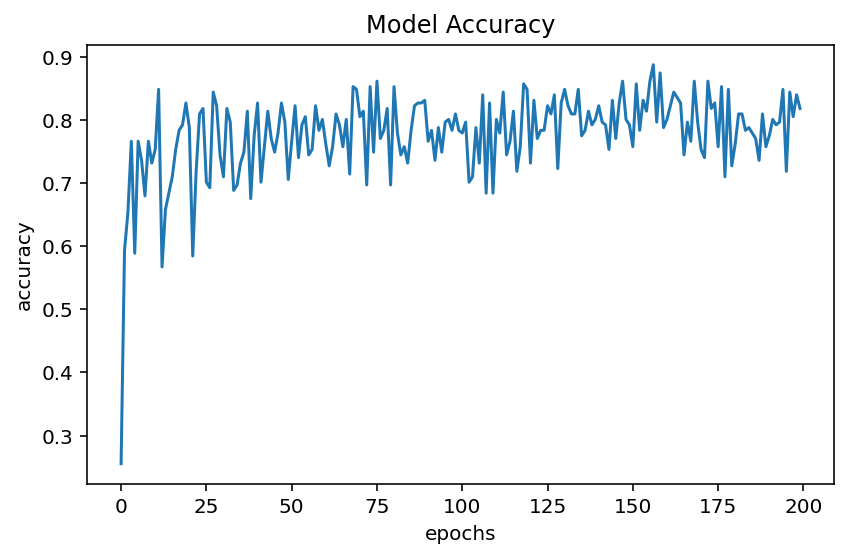

In [41]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(176, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(90, activation='relu'),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dense(70, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(21)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(X_train_c, y_train_c, epochs=200)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.tight_layout()
plt.savefig('../output/plots/6.3.1 Accuracy Plot.png')

scores = model.history.history['accuracy'][-1]
output_file = open('../output/output_file', 'a')
model_no = 'Model#: 6.3.1\n'
model_type = 'Neural Network (midi and wav data)\n'
model_scores = f'Accuracy Score {scores}\n'
output_file.writelines([model_no, model_type, model_scores])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)
pass

### Observation : Cases removed through SMOTE run on the training data will not be classified correctly in the test data.

# Development Results

| Model Type          | Feature Set | Model Variant                                           | Highest CV Score | Mean CV Score |
|---------------------|-------------|---------------------------------------------------------|------------------|---------------|
| Logistic Regression | Spectral    | Baseline                                                | 94.23%           | 89.75%        |
| Logistic Regression | Spectral    | PCA                                                     | 71.15%           | 68.83%        |
| Logistic Regression | Midi        | Baseline                                                | 76.92%           | 71.10%        |
| Logistic Regression | Midi        | PCA                                                     | 48.08%           | 41.49%        |
| Logistic Regression | Combined    | Baseline                                                | 90.38%           | 86.31%        |
| Logistic Regression | Combined    | PCA                                                     | 48.08%           | 46.02%        |
| Naive Bayes         | Spectral    | Baseline                                                | 71.69%           | 68.41%        |
| Naive Bayes         | Midi        | Baseline                                                | 75.00%           | 59.00%        |
| Naive Bayes         | Combined    | Baseline                                                | 75.47%           | 73.00%        |
| Random Forest       | Spectral    | Baseline                                                | 86.54%           | 82.54%        |
| Random Forest       | Spectral    | w/SMOTE                                                 | 100%             | 99.56%        |
| Random Forest       | Spectral    | w/SMOTE +  Hyperparameter Tuning                        | ?                | ?             |
| Random Forest       | Midi        | Baseline                                                | 97.87%           | 96.10%        |
| Random Forest       | Midi        | w/SMOTE                                                 | 99.56%           | 99.34%        |
| Random Forest       | Midi        | w/SMOTE + Hyperparameter Tuning                         | ?                | ?             |
| Random Forest       | Combined    | Baseline                                                | 94.23%           | 85.20%        |
| Random Forest       | Combined    | w/SMOTE                                                 | 100%             | 99.29%        |
| Random Forest       | Combined    | w/SMOTE + Hyperparameter Tuning                         | ?                | ?             |
| SVM                 | Spectral    | Baseline                                                | 61.54%           | 58.19%        |
| SVM                 | Spectral    | w/Hyperparameter Tuning                                 | 90.38%           | 85.59%        |
| SVM                 | Spectral    | w/Hyperparamater Tuning + PCA                           | 92.31%           | 84.46%        |
| SVM                 | Spectral    | w/Hyperparameter Tuning + PCA + SMOTE                   | 100%             | 99.29%        |
| SVM                 | Spectral    | w/Hyperparameter Tuning +  PCA + SMOTE + MinMaxScaler   | 76.00%           | 69.07%        |
| SVM                 | Spectral    | w/Hyperparameter Tuning +  PCA + SMOTE + StandardScaler | 92.89%           | 90.93%        |
| SVM                 | Midi        | Baseline                                                | 67.31%           | 65.41%        |
| SVM                 | Midi        | w/Hyperparameter Tuning                                 | ?                | ?             |
| SVM                 | Midi        | w/SMOTE                                                 | ?                | ?             |
| SVM                 | Midi        | w/PCA                                                   | ?                | ?             |
| SVM                 | Combined    | Baseline                                                | 67.31%           | 65.03%        |
| SVM                 | Combined    | w/Hyperparameter Tuning                                 | ?                | ?             |
| SVM                 | Combined    | w/SMOTE                                                 | ?                | ?             |
| SVM                 | Combined    | w/PCA                                                   | ?                | ?             |
| Neural Network      | Spectral    | Baseline (ADAM, 5 Hidden Layers)                        | 100%             | 100%          |
| Neural Network      | Midi        | Baseline (ADAM, 5 Hidden Layers)                        | 100%             | 100%          |
| Neural Network      | Combined    | Baseline (ADAM, 5 Hidden Layers)                        | ?                | ?             |

The Top 10 model-data combinations with the highest accuracy during cross-validation were 
1. Neural Network - Spectral
2. Neural Network - Midi
3. Random Forest w/SMOTE - Spectral
4. Random Forest w/SMOTE - Midi
5. Random Forest w/SMOTE - Combined
6. SVM w/Hyper Parameter Tuning + PCA + SMOTE - Spectral
7. Random Forest - Midi
8. SVM w/Hyper Parameter Tuning + PCA + SMOTE + StandardScaler - Spectral
9. Logistic Regression - Spectral
10. Logistic Regression - Combined

# Test Set Performance

### Neural Network - Spectral

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(176, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(90, activation='relu'),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dense(70, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(21)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(X_train_w, y_train_w, epochs=200)
predictions = model.predict(X_test_w)
accuracy = accuracy_score(predictions,y_test_w)
print("Test Set Accuracy: {:.2%}".format(accuracy))

Epoch 1/200
9/9 [==============================] - 2s 6ms/step - loss: 6.1299 - accuracy: 0.1217
Epoch 2/200
9/9 [==============================] - 0s 4ms/step - loss: 2.0974 - accuracy: 0.4715
Epoch 3/200
9/9 [==============================] - 0s 9ms/step - loss: 1.7452 - accuracy: 0.5171
Epoch 4/200
9/9 [==============================] - 0s 3ms/step - loss: 1.4600 - accuracy: 0.6236
Epoch 5/200
9/9 [==============================] - 0s 3ms/step - loss: 1.3227 - accuracy: 0.6996
Epoch 6/200
9/9 [==============================] - 0s 3ms/step - loss: 1.2489 - accuracy: 0.6882
Epoch 7/200
9/9 [==============================] - 0s 3ms/step - loss: 1.1360 - accuracy: 0.7034
Epoch 8/200
9/9 [==============================] - 0s 5ms/step - loss: 1.0446 - accuracy: 0.7300
Epoch 9/200
9/9 [==============================] - 0s 3ms/step - loss: 1.0120 - accuracy: 0.7300
Epoch 10/200
9/9 [==============================] - 0s 4ms/step - loss: 0.9690 - accuracy: 0.7338
Epoch 11/200
9/9 [===========

9/9 [==============================] - 0s 3ms/step - loss: 0.0920 - accuracy: 0.9696
Epoch 85/200
9/9 [==============================] - 0s 5ms/step - loss: 0.0796 - accuracy: 0.9658
Epoch 86/200
9/9 [==============================] - 0s 4ms/step - loss: 0.0969 - accuracy: 0.9734
Epoch 87/200
9/9 [==============================] - 0s 3ms/step - loss: 0.0567 - accuracy: 0.9848
Epoch 88/200
9/9 [==============================] - 0s 5ms/step - loss: 0.0530 - accuracy: 0.9886
Epoch 89/200
9/9 [==============================] - 0s 4ms/step - loss: 0.0411 - accuracy: 0.9886
Epoch 90/200
9/9 [==============================] - 0s 4ms/step - loss: 0.0332 - accuracy: 0.9924
Epoch 91/200
9/9 [==============================] - 0s 4ms/step - loss: 0.0192 - accuracy: 0.9962
Epoch 92/200
9/9 [==============================] - 0s 3ms/step - loss: 0.0149 - accuracy: 1.0000
Epoch 93/200
9/9 [==============================] - 0s 4ms/step - loss: 0.0128 - accuracy: 1.0000
Epoch 94/200
9/9 [===============

9/9 [==============================] - 0s 4ms/step - loss: 8.8879e-04 - accuracy: 1.0000
Epoch 167/200
9/9 [==============================] - 0s 6ms/step - loss: 8.6063e-04 - accuracy: 1.0000
Epoch 168/200
9/9 [==============================] - 0s 5ms/step - loss: 8.4720e-04 - accuracy: 1.0000
Epoch 169/200
9/9 [==============================] - 0s 5ms/step - loss: 8.3752e-04 - accuracy: 1.0000
Epoch 170/200
9/9 [==============================] - 0s 5ms/step - loss: 8.1564e-04 - accuracy: 1.0000
Epoch 171/200
9/9 [==============================] - 0s 6ms/step - loss: 7.8819e-04 - accuracy: 1.0000
Epoch 172/200
9/9 [==============================] - 0s 5ms/step - loss: 7.7776e-04 - accuracy: 1.0000
Epoch 173/200
9/9 [==============================] - 0s 6ms/step - loss: 7.6976e-04 - accuracy: 1.0000
Epoch 174/200
9/9 [==============================] - 0s 5ms/step - loss: 7.6525e-04 - accuracy: 1.0000
Epoch 175/200
9/9 [==============================] - 0s 6ms/step - loss: 7.4070e-04 - a

ValueError: Classification metrics can't handle a mix of continuous-multioutput and multiclass targets

### Neural Network - Midi

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(176, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(90, activation='relu'),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dense(70, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(21)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(X_train_m, y_train_m, epochs=200)
predictions = model.predict(X_test_m)
accuracy = accuracy_score(predictions,y_test_m)
print("Test Set Accuracy: {:.2%}".format(accuracy))

### Random Forest w/SMOTE - Spectral

In [8]:
# todo: I think we need to re-import the data for this cell, if this is run multiple times then y_train_w gets overwritten
y_train_w = pd.read_csv('../data/y_train_w.csv',index_col = 0)

#Drop any ensemble types with counts below 6. This because Expected n_neighbors <= n_samples,  
#but n_samples = 3, n_neighbors = 6
counts = y_train_w['ensemble'].value_counts()
X_train_w = X_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]
y_train_w = y_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]

# Fit and apply the transform
X_SMOTE_w, y_SMOTE_w = SMOTE(random_state=101).fit_resample(X_train_w, y_train_w)

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1)
rf.fit(X_SMOTE_w, y_SMOTE_w)
predictions = rf.predict(X_test_w)
accuracy = accuracy_score(predictions,y_test_w)
print("Test Set Accuracy: {:.2%}".format(accuracy))

Test Set Accuracy: 75.76%


### Random Forest w/SMOTE - Midi

In [11]:
# todo: I think we need to re-import the data for this cell, if this is run multiple times then y_train_w gets overwritten
y_train_m = pd.read_csv('../data/y_train_m.csv',index_col = 0)

#Drop any ensemble types with counts below 6. This because Expected n_neighbors <= n_samples,  
#but n_samples = 3, n_neighbors = 6
counts = y_train_m['ensemble'].value_counts()
X_train_m = X_train_m[~y_train_m['ensemble'].isin(counts[counts < 6].index)]
y_train_m = y_train_m[~y_train_m['ensemble'].isin(counts[counts < 6].index)]

# Fit and apply the transform
X_SMOTE_m, y_SMOTE_m = SMOTE(random_state=101).fit_resample(X_train_m, y_train_m)

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1)
rf.fit(X_SMOTE_m, y_SMOTE_m)
predictions = rf.predict(X_test_m)
accuracy = accuracy_score(predictions,y_test_m)
print("Test Set Accuracy: {:.2%}".format(accuracy))


Test Set Accuracy: 83.33%


### Random Forest w/SMOTE - Combined

In [12]:
# todo: I think we need to re-import the data for this cell, if this is run multiple times then y_train_w gets overwritten
y_train_c = pd.read_csv('../data/y_train_c.csv',index_col = 0)

#Drop any ensemble types with counts below 6. This because Expected n_neighbors <= n_samples,  
#but n_samples = 3, n_neighbors = 6
counts = y_train_c['ensemble'].value_counts()
X_train_c = X_train_c[~y_train_c['ensemble'].isin(counts[counts < 6].index)]
y_train_c = y_train_c[~y_train_c['ensemble'].isin(counts[counts < 6].index)]

X_SMOTE_c, y_SMOTE_c = SMOTE(random_state=101).fit_resample(X_train_c, y_train_c)

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1)
rf.fit(X_SMOTE_c, y_SMOTE_c)
predictions = rf.predict(X_test_c)
accuracy = accuracy_score(predictions,y_test_c)
print("Test Set Accuracy: {:.2%}".format(accuracy))

Test Set Accuracy: 80.30%


### SVM w/Hyper Parameter Tuning + PCA + SMOTE - Spectral

In [14]:
print("Before oversampling: ",Counter(y_train_w.values.ravel()))

#Drop any ensemble types with counts below 6
counts = y_train_w['ensemble'].value_counts()
X_train_w_smote = X_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]
y_train_w_smote = y_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]

#Now print data shape
print(X_train_w_smote.shape, y_train_w_smote.shape)

# fit and apply the transform
X_SMOTE, y_SMOTE = SMOTE().fit_resample(X_train_w_smote, y_train_w_smote.values.ravel())

# summarize class distribution
print("After oversampling: ",Counter(y_SMOTE))

#Perform PCA with 15 components
pca=PCA(n_components = 15)
pca.fit(X_SMOTE)
train_pca_w_smote = pca.transform(X_SMOTE)
X_test_w_pca = pca.transform(X_test_w)


from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': np.logspace(-4, 4, 20), 
              'gamma': np.logspace(-3, 2, 6),
              'kernel': ['linear','rbf','poly']} 
  
grid = GridSearchCV(SVC(), param_grid , cv=5)
  
# fitting the model for grid search
grid.fit(train_pca_w_smote, y_SMOTE)

print(grid.best_params_)

#Create SVM model with best hyperparameters, PCA and SMOTE

svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_w_smote, y_SMOTE)
predictions = svm.predict(X_test_w_pca)
accuracy = accuracy_score(predictions,y_test_w)
print("Test Set Accuracy: {:.2%}".format(accuracy))

Before oversampling:  Counter({1: 125, 4: 46, 19: 18, 16: 10, 14: 7, 7: 7, 12: 6, 8: 6, 2: 6, 6: 5, 11: 4, 20: 3, 13: 3, 0: 3, 9: 3, 17: 3, 10: 2, 5: 2, 15: 2, 18: 2})
(231, 167) (231, 1)
After oversampling:  Counter({19: 125, 1: 125, 12: 125, 14: 125, 16: 125, 4: 125, 7: 125, 8: 125, 2: 125})
{'C': 0.012742749857031334, 'gamma': 0.001, 'kernel': 'linear'}
Test Set Accuracy: 77.27%


### Random Forest - Midi

# SVM Conclusion :

- The MIDI data and Data Set containing MIDI data could not complete running on the SVM model.

- One clue we have here on why the SVM model struggles with classifying the MIDI data is that the best C value is extremely high at 10,000. In other words, very low regularization strength and extreme overfitting is required to fit the model well.

- In conclusion, the best SVM model was run on spectral data and has a 5-fold cross-validation score of 99.47% with standard deviation of 0.00653 when a cross validation was done on training data,

- It has PCA with 15 components, SMOTE application to balance the sample classes and also hyperparameter tuning where we found the best C, best gamma and also that linear kernel is the best kernel to use amongst the 3 types that are available.

- When run on test data, the best SVM model had an F1 Score of 84.17%.


In [43]:
### Best SVM Model using Spectral Data

In [61]:
#Drop any ensemble types with counts below 6
counts = y_train_w['ensemble'].value_counts()
X_train_w_smote = X_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]
y_train_w_smote = y_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]

# fit and apply the transform
X_SMOTE, y_SMOTE = SMOTE().fit_resample(X_train_w_smote, y_train_w_smote.values.ravel())

#Perform PCA with 15 components
pca=PCA(n_components = 15)
pca.fit(X_SMOTE)
train_pca_w_smote = pca.transform(X_SMOTE)

from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': np.logspace(-4, 4, 20), 
              'gamma': np.logspace(-3, 2, 6),
              'kernel': ['linear','rbf','poly']} 
  
grid = GridSearchCV(SVC(), param_grid , cv=5)
  
# fitting the model for grid search
grid.fit(train_pca_w_smote, y_SMOTE)

print(grid.best_params_)

#Create SVM model with best hyperparameters, PCA and SMOTE

svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_w_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_w_smote, y=y_SMOTE, cv=5, n_jobs=1)

test_pca_w = pca.transform(X_test_w)
predictions_pca_w = svm.predict(test_pca_w)

output_file = open('../output/output_file', 'a')
model_iteration = 'Final Model\n'
model_type = 'SVM with SMOTE, PCA (wav data only)\n'
model_scores = f'Accuracy score: {accuracy_score(predictions_pca_w, np.array(y_test_w))}, F1 score: {f1_score(predictions_pca_w, np.array(y_test_w), average="weighted")}\n'
cr = f'Classification report: \n {classification_report(np.array(y_test_w), predictions_pca_w)}'
cm = f'Confusion matrix: \n {confusion_matrix(np.array(y_test_w), predictions_pca_w)}'
output_file.writelines([model_iteration, model_type, model_scores, cr, cm])
output_file.close()
print(model_iteration, model_type, model_scores)

{'C': 0.03359818286283781, 'gamma': 0.001, 'kernel': 'linear'}


TypeError: 'str' object is not callable